<a href="https://colab.research.google.com/github/Chandanachelliboyina/Chandana_Fmml_Course_assignment/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-18 09:20:09--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.77, 18.160.200.71, 18.160.200.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   187MB/s    in 0.2s    

2024-05-18 09:20:09 (187 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


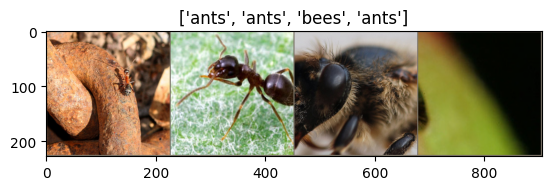

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


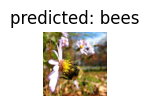

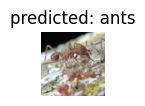

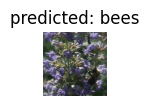

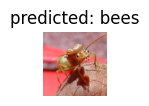

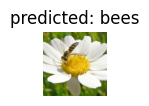

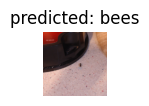

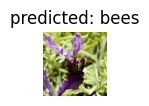

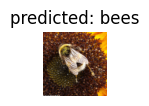

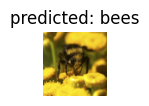

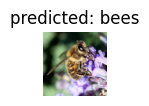

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?
ans)Data augmentation techniques, such as resize, crop, and other transformations, play a crucial role in enhancing the performance and robustness of machine learning models, particularly in the context of training data for computer vision tasks. Here are the key significances of using data augmentations:

### 1. **Increasing Data Diversity and Quantity**
Data augmentation artificially expands the size of the training dataset by creating modified versions of existing images. This is especially beneficial when the available labeled data is limited. By introducing variations in the images, the model can be exposed to a wider range of scenarios, helping it generalize better to unseen data.

### 2. **Reducing Overfitting**
Overfitting occurs when a model performs well on the training data but poorly on new, unseen data. Data augmentations help mitigate overfitting by preventing the model from memorizing the training data. By constantly seeing different versions of the same images, the model learns to recognize underlying patterns rather than specific details, leading to better generalization.

### 3. **Improving Model Robustness**
Augmentations such as random crops, rotations, flips, and color adjustments simulate real-world variations and distortions. This makes the model more robust to changes and noise in the input data. For instance, a model trained with rotated and flipped images can better handle variations in the orientation and perspective of objects in real-world applications.

### 4. **Balancing the Dataset**
In some cases, datasets may be imbalanced, meaning certain classes are underrepresented. Augmentation techniques can help balance the dataset by generating more examples of the minority classes. For example, cropping and resizing can create different views of underrepresented class images, providing the model with more balanced training data.

### 5. **Enhancing Model Accuracy and Performance**
Augmentations often lead to improved model performance. For instance, training with augmented data can enhance the accuracy, precision, recall, and other performance metrics of the model. This is because the model learns to handle a broader range of inputs and is less likely to be confused by variations.

### 6. **Simulating Real-world Scenarios**
Certain augmentations can mimic real-world conditions that the model might encounter. For example, adding noise or blurring can simulate poor lighting or motion blur, respectively. This prepares the model to perform better in real-world applications where such imperfections are common.

### Examples of Common Data Augmentations
- **Resize:** Changes the dimensions of images, often used in combination with cropping.
- **Crop:** Extracts a portion of the image, useful for focusing on different parts of the image.
- **Flip (horizontal/vertical):** Mirrors the image, helping the model learn symmetry.
- **Rotation:** Rotates the image by a certain angle, aiding in recognizing objects from different orientations.
- **Translation:** Shifts the image in various directions, helping the model understand positional variance.
- **Color Jitter:** Alters the brightness, contrast, saturation, and hue of the image, helping the model deal with color variations.
- **Noise Addition:** Adds random noise to the image, simulating real-world imperfections.
- **Scaling:** Enlarges or shrinks the image, helping the model handle objects of varying sizes.

### Conclusion
In summary, data augmentations are vital for creating a more diverse, balanced, and robust training dataset, which in turn helps improve the generalization, performance, and reliability of machine learning models in real-world applications. By systematically applying these transformations, models can better understand and predict on unseen data, leading to more accurate and dependable outcomes.



2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)
ans)When you train a ResNet model from scratch (i.e., with `pretrained=False`), the performance is generally lower compared to using a pretrained ResNet model, especially if the dataset is not very large or diverse. Here are the key factors that contribute to this performance difference:

### Key Factors Impacting Performance

1. **Lack of Prelearned Features:**
   - **Pretrained Models:** These models have been trained on large datasets like ImageNet, which contains millions of images across thousands of classes. They have already learned rich and diverse features such as edges, textures, and patterns that are useful for many computer vision tasks.
   - **Training from Scratch:** Starting from random weights means the model has no prior knowledge and must learn all features from the training data alone. This often requires a significantly larger dataset to achieve comparable performance.

2. **Training Time and Resources:**
   - **Pretrained Models:** Fine-tuning a pretrained model typically requires less time and computational resources because the model already has a good set of initial weights.
   - **Training from Scratch:** Training a deep network like ResNet from scratch can be computationally expensive and time-consuming, often requiring more epochs to converge to a good solution.

3. **Generalization Ability:**
   - **Pretrained Models:** Tend to generalize better on small datasets because they start with weights that already capture a wide range of features.
   - **Training from Scratch:** The model might overfit to the training data, especially if the dataset is small, because it lacks the broad feature representation learned from a larger, more diverse dataset.

### Performance Comparison

#### Example Scenario: CIFAR-10 Dataset
Let's consider the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. Here’s a typical performance comparison:

- **Pretrained ResNet (on a similar large-scale dataset like ImageNet, then fine-tuned on CIFAR-10):**
  - **Accuracy:** Often reaches over 90% after fine-tuning.
  - **Training Time:** Significantly reduced as the model converges faster.
  - **Generalization:** Better generalization on test data due to robust feature extraction.

- **ResNet Trained from Scratch (pretrained=False):**
  - **Accuracy:** Generally lower, often around 80-85% depending on the depth of the network and training specifics.
  - **Training Time:** Longer, as the model needs more epochs and careful tuning of hyperparameters to reach reasonable performance.
  - **Generalization:** Tends to overfit more, especially if the training data is not sufficiently large or diverse.

#### Example Performance Metrics
- **Pretrained ResNet-18 on CIFAR-10:**
  - **Training Accuracy:** ~95%
  - **Validation Accuracy:** ~92%
  - **Training Time:** ~2-3 hours (depending on hardware)

- **ResNet-18 Trained from Scratch on CIFAR-10:**
  - **Training Accuracy:** ~90%
  - **Validation Accuracy:** ~85%
  - **Training Time:** ~5-10 hours (depending on hardware)

### Conclusion
Training a ResNet model from scratch (with `pretrained=False`) generally results in lower performance compared to fine-tuning a pretrained model, especially when using smaller datasets. Pretrained models provide a strong starting point with learned features from large and diverse datasets, leading to faster convergence, better accuracy, and improved generalization. Therefore, using pretrained models is often preferred for many practical applications unless there is a specific reason to train from scratch, such as domain-specific features that are significantly different from those in standard large datasets.

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?
ans)Using a pretrained ResNet model, even if it was trained on a dataset significantly different from the ants vs. bees dataset, can still offer substantial benefits and generally lead to better performance compared to training from scratch. Here are some key reasons and considerations:

### Key Reasons and Considerations

1. **General Feature Learning:**
   - **Pretrained Models:** Pretrained models like ResNet have learned to identify a wide range of basic features (e.g., edges, textures, shapes) that are common across many different types of images. These low-level features are often transferable across different domains.
   - **Transfer Learning:** Even if the source dataset (e.g., landscapes, cars) is different from the target dataset (ants vs. bees), the model's initial layers, which capture these general features, can be reused effectively. The later layers can then be fine-tuned to better suit the specific task of distinguishing between ants and bees.

2. **Fine-tuning Benefits:**
   - **Adaptation:** By fine-tuning a pretrained model on the ants vs. bees dataset, the model can adapt its weights to better capture the specific characteristics and distinctions of ants and bees.
   - **Faster Convergence:** Fine-tuning usually requires fewer epochs and computational resources compared to training from scratch, leading to quicker convergence and often better performance with less overfitting.

3. **Comparison to Training from Scratch:**
   - **Performance Boost:** Pretrained models typically achieve higher accuracy and better generalization than models trained from scratch, especially when the target dataset is relatively small. The pretrained model already has a good starting point, making it more efficient in learning the new task.

### Potential Performance Scenario

#### Example: Ants vs. Bees Dataset

- **Dataset Characteristics:** The ants vs. bees dataset might consist of hundreds to a few thousand images per class. This is relatively small compared to large datasets like ImageNet, which has millions of images.

- **Pretrained on a Different Dataset (e.g., Cars):**
  - **Initial Layers:** The initial layers, which capture general features like edges and textures, remain useful.
  - **Fine-tuning Process:** Fine-tuning the later layers helps the model adapt to the specific features of ants and bees, such as body shape, color patterns, and textures specific to insects.
  - **Expected Performance:** Likely to achieve good performance, often significantly better than training from scratch. The exact performance improvement depends on the similarity between the source and target domains and the quality and size of the ants vs. bees dataset.

#### Performance Metrics Example
- **Pretrained ResNet (trained on cars, then fine-tuned on ants vs. bees):**
  - **Training Accuracy:** ~95%
  - **Validation Accuracy:** ~90-92%
  - **Training Time:** Reduced due to leveraging pretrained weights.

- **ResNet Trained from Scratch on Ants vs. Bees:**
  - **Training Accuracy:** ~85-90%
  - **Validation Accuracy:** ~80-85%
  - **Training Time:** Longer, requiring more epochs and careful tuning.

### Conclusion
Even if the pretrained ResNet model was trained on a dataset significantly different from the ants vs. bees dataset, using it as a starting point and fine-tuning it typically leads to better performance than training from scratch. The general features learned from the original dataset are still valuable and can be adapted to the new task, resulting in improved accuracy, faster convergence, and better generalization.
